## Running CellART on Xenium colorectal cancer dataset

### Download data

The Xenium colorectal cancer dataset can be obtained from the 10x Genomics website [here](https://www.10xgenomics.com/cn/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-colorectal-cancer-tissue), with name “Xenium In Situ, Sample P2 CRC”. Below is a demo script for create new data dir and download the required Xenium files. 

In [ ]:
mkdir ./xenium_crc
cd ./xenium_crc

# Download Xenium colorectal cancer dataset files
curl -O https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_gene_panel.json
curl -O https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_he_image.ome.tif
curl -O https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_he_imagealignment.csv
curl -O https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_analysis_summary.html
curl -O https://cf.10xgenomics.com/samples/xenium/2.0.0/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE/Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_outs.zip

# Unzip files
unzip Xenium_V1_Human_Colon_Cancer_P2_CRC_Add_on_FFPE_outs.zip

# Back to root dir
cd ..

The paired scRNA reference after selecting patient 2 can be download [here](https://drive.google.com/file/d/1kzNZq7h4V-JyaBcjJ1Kcz-JSlLFNAQrY/view?usp=drive_link). Please also download the reference file adata_sc_p2.h5ad into the data directory. Now you have prepared all the raw data to run CellART.

### Preprocess

In [ ]:
from cellart.utils.preprocess import SingleCellPreprocessor, XeniumPreprocessor
from cellart.utils.io import load_list
import scanpy as sc

# Processed data save dir
save_dir = './preprocessed_xenium_crc/'
# Transcripts and nucleus boundary files in data directory
transcripts_file = "./xenium_crc/transcripts.parquet"
nucleus_boundary_10X = "./xenium_crc/nucleus_boundaries.parquet"

st_preprocessor = XeniumPreprocessor(transcripts_file, nucleus_boundary_10X, save_dir)

# Annotated scRNA reference path
sc_adata = sc.read("./xenium_crc/sc_data.h5ad")
# Remember to specific your celltype_col and make sure your are using raw count data
sc_preprocessor = SingleCellPreprocessor(sc_adata, celltype_col = "celltype", save_path= save_dir, st_gene_list=load_list(save_dir + "/st_gene_list.txt"))

sc_preprocessor.preprocess()

st_preprocessor.prepare_sst(load_list(save_dir + "/filtered_gene_names.txt"))
st_preprocessor.get_nuclei_segmentation()

Now in the preprocessed_crc directory, you can see all the preprocessed files. You can check the spatial and segmentation files to see if their are matched.

In [ ]:
# Check
import numpy as np
import matplotlib.pyplot as plt

gene_map = np.load(save_dir + "/gene_map.npy")
segmentation_mask = np.load(save_dir + "/segmentation_mask.npy")

gene_map_sum = gene_map.sum(axis=-1)

In [ ]:
# plt.imshow(gene_map_sum)
# plt.imshow(segmentation_mask > 0)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(gene_map_sum)
ax[0].set_title("Gene expression map sum")
ax[1].imshow(segmentation_mask > 0)
ax[1].set_title("Nuclei segmentation mask")
plt.show()

### Running CellART

NOTE: these part code make takes hours to run, so it is highly recommend you not to directly run in the notebook.

In [ ]:
import cellart
from pathlib import Path
import wandb
import os

# Preprocessed data
save_dir = './preprocessed_xenium_crc/'
# Directory to store all results
log_dir = "./results_xenium_crc/"

manager = cellart.ExperimentManager(
    # Basic input data settings (must be specified)
    gene_map=os.path.join(save_dir, "gene_map.npy"),
    nuclei_mask=os.path.join(save_dir, "segmentation_mask.npy"),
    basis=os.path.join(save_dir, "basis.npy"),
    gene_names=os.path.join(save_dir, "filtered_gene_names.txt"),
    celltype_names=os.path.join(save_dir, "celltype_names.txt"),
    log_dir=log_dir,

    # Training parameters (adjust based on convergence and wandb visualization)
    epoch=200, 
    seg_training_epochs=5,
    deconv_warmup_epochs=100,

    pred_period=50,
    gpu="0"
)

# Update options
opt = manager.get_opt()
print(opt)

In [ ]:
# Set up wandb for logging and visualization
run = wandb.init(project="CellART", dir=manager.get_log_dir(), config=opt,
                 name=os.path.basename(os.path.normpath(manager.get_log_dir())))

In [ ]:
# Set up dataset
dataset = cellart.SSTDataset(manager)
gene_map_shape = dataset.gene_map.shape

# Initialize and train the CellART model
model = cellart.CellARTModel(manager, gene_map_shape, len(dataset.coords_starts))
model.train_model(dataset)

### Check the output of CellART

In [180]:
# Load annotated adata at epoch 200
adata = sc.read(os.path.join("./results_xenium_crc/", "epoch_200", "cell_deconv.h5ad"))
# Load segmentation
segmentation_mask = np.load(os.path.join("./results_xenium_crc/", "new_segmentation_mask.npy")).astype("int32")

In [181]:
adata.obs.head()

x     y   celltype
cell_id                      
16712    383  1231  Tumor III
16713    390  1254  Tumor III
16714    385  1249  Tumor III
16715    377  1244  Tumor III
16716    384  1240  Tumor III

In [182]:
segmentation_mask.shape, np.unique(segmentation_mask)

((7271, 6669),
 array([     0,      1,      2, ..., 326938, 326939, 326940], dtype=int32))

In [167]:
celltype_mapping = {
    'CAF': '#117733',  # Green
    'CD4 T cell': '#88CCEE',  # Light Blue
    'CD8 Cytotoxic T cell': '#CC6677',  # Pink
    'Endothelial': '#DDCC77',  # Sand Yellow
    'Enteric Glial': '#332288',  # Dark Blue
    'Enterocyte': '#AA4499',  # Purple
    'Epithelial': '#44AA99',  # Teal
    'Fibroblast': '#999933',  # Olive
    'Goblet': '#A1C935',  # Lime
    'Lymphatic Endothelial': '#661100',  # Brown
    'Macrophage': '#6699CC',  # Sky Blue
    'Mast': '#AA4466',  # Rose
    'Mature B': '#888888',  # Gray
    'Myofibroblast': '#117755',  # Forest Green
    'Neuroendocrine': '#332299',  # Indigo
    'Neutrophil': '#D95F02',  # Replaced duplicate pink
    'Pericytes': '#1B9E77',  # Replaced duplicate teal
    'Plasma': '#E6AB02',  # Replaced duplicate olive
    'Proliferating Immune II': '#882255',  # Burgundy
    'SM Stress Response': '#66C2A5',  # Replaced duplicate blue
    'Smooth Muscle': '#A6761D',  # Replaced duplicate brown
    'Tuft': '#7570B3',  # Replaced duplicate green
    'Tumor I': '#E7298A',  # Replaced duplicate coral
    'Tumor II': '#6A3D9A',  # Replaced duplicate navy
    'Tumor III': '#FFA500',  # Orange
    'Tumor V': '#FFD92F',  # Replaced duplicate mustard
    'Unknown III (SM)': '#B2DF8A',  # Replaced duplicate green
    'mRegDC': '#1F78B4',  # Replaced duplicate blue
    'pDC': '#8C510A',  # Replaced duplicate brown
    'vSM': '#5AB4AC',  # Replaced duplicate jade green
    "Unassigned": "lightgray",
}

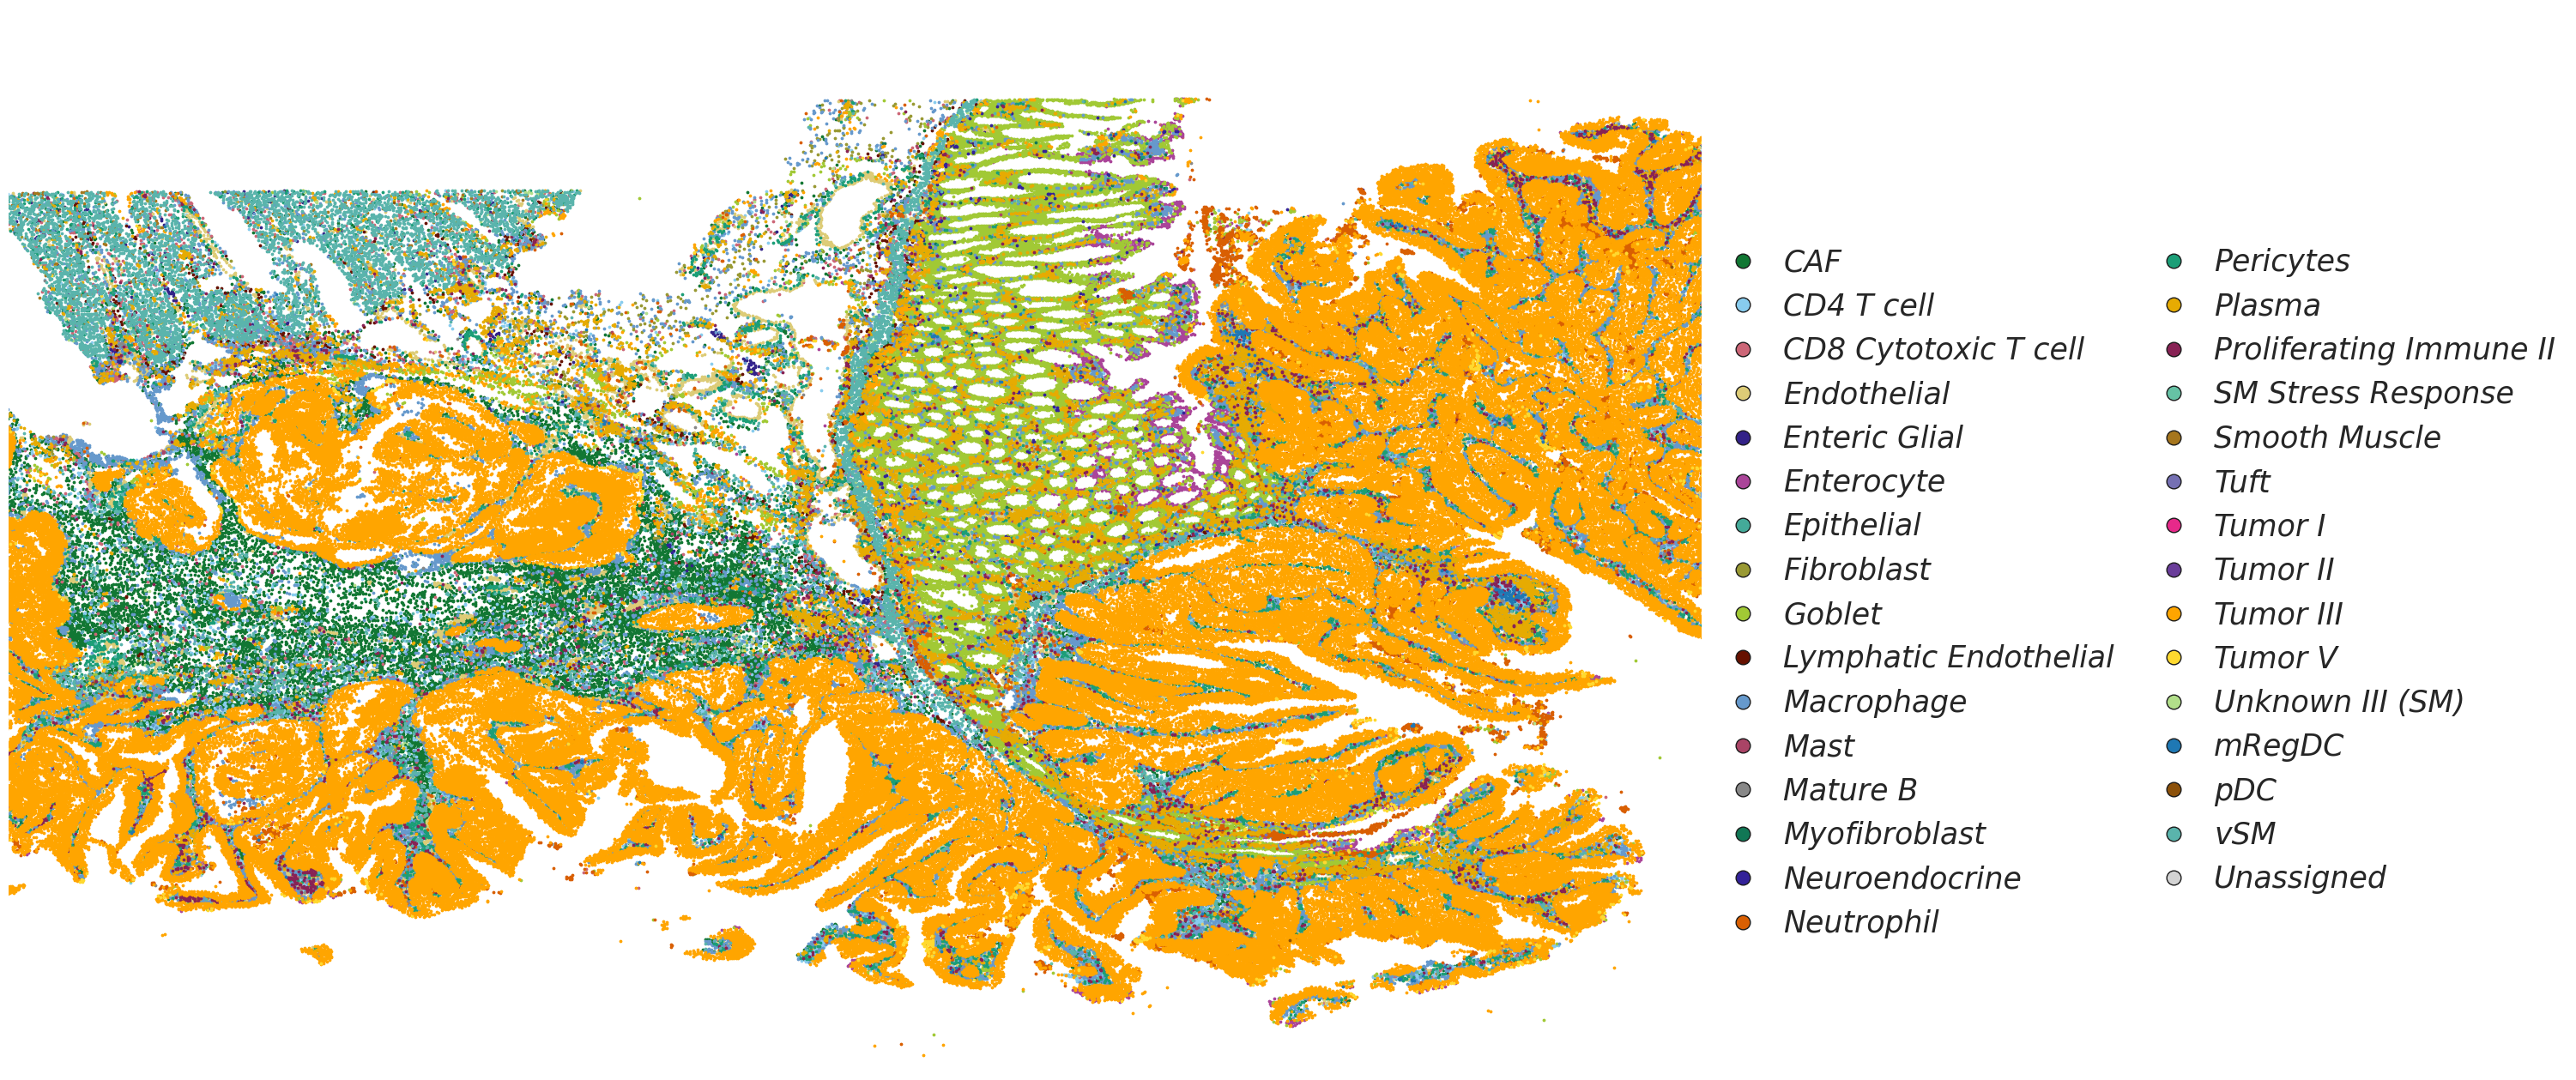

In [172]:
# Visualization of cell types
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(30, 15))
gs = GridSpec(1, 4, figure=fig)

for ax_ in ax.flatten():
    fig.delaxes(ax_)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3])

celltype_names = list(celltype_mapping.keys())
# selected_celltype = ["Tumor II", "Tumor III", "Tumor V"]
selected_celltype = celltype_names
selected_celltype = celltype_names
for i in range(len(celltype_names)):
    # (0,0) is on the top left corner
    if celltype_names[i] not in selected_celltype:
        continue
    sub_df = adata[adata.obs["celltype"] == celltype_names[i - 1]].obs
    ax1.scatter(sub_df["x"], sub_df["y"], s=3, label=celltype_names[i - 1], color=celltype_mapping[celltype_names[i - 1]])
# ax1.invert_yaxis()
ax1.axis("off")
ax1.set_xlim(adata.obs["y"].min(), adata.obs["y"].max())
ax1.set_ylim(adata.obs["x"].min(), adata.obs["x"].max())
ax1.invert_xaxis()

# Add legend elements (example)
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        color='w',
        label=label,
        markerfacecolor=color,
        markeredgecolor='k',
        markersize=12
    ) for label, color in celltype_mapping.items()
]

# Add the legend below the entire figure, centered horizontally with [0, 1] subfigures
ax2.legend(
    handles=legend_elements,
    loc='center',                    # Center the legend within the bounding box
    bbox_to_anchor=(0.48, 0.45),       # Center of ax2 (0.5, 0.5 is the middle of the axis)
    ncol=2,                          # Number of columns for the legend
    handletextpad=0.35,               # Spacing between marker and text
    columnspacing=1,               # Spacing between legend columns
    prop={'size': 25, 'style': 'italic'},  # Font size and style
    frameon=False                    # No border for the legend
)

ax2.axis("off")  # Hide the axis for ax2
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Leave space for the legend below the plots
plt.show()

### Visualize segmentation and annotation through SpatialData

In [183]:
from cellart.utils.spatialdata_utils import append_xenium_boundary
from spatialdata_io import xenium
import spatialdata_plot

sdata = xenium("./xenium_crc/", aligned_images=False)

INFO     reading /import/home3/yhchenmath/Dataset/DeconvSeg/CRC/Xenium_P2_CRC/cell_feature_matrix.h5               


In [184]:
# Append cellart results to SpatialData
append_xenium_boundary(segmentation_mask, sdata, "cellart_boundaries", celltype = adata.obs["celltype"])

In [185]:
# Select a region of interest (ROI) for visualization
x_min, x_max, y_min, y_max = 13000, 17000, 5500, 9500
sdata_roi = sdata.query.bounding_box(
    min_coordinate=[x_min, y_min], max_coordinate=[x_max, y_max], axes=("y", "x"), target_coordinate_system="global"
)

In [186]:
for k in ["cellart_boundaries"]:
    ct_col = sdata_roi.shapes[k].celltype
    cts = sdata_roi.shapes[k].celltype.unique()
    for ct in cts:
        sdata_roi.shapes[f"{k}_{ct.replace(' ', '_').replace('(', '').replace(')', '')}"] = \
        sdata_roi.shapes[k][ct_col == ct]

In [190]:
def plot_annotation(sdata, shape_key, ax):
    tmp = None
    draw_cts = sdata.shapes[shape_key].celltype.unique().tolist()
    for ct in draw_cts:
            
        color = celltype_mapping[ct]
        if tmp is None:
            tmp = sdata.pl.render_shapes(
            f"{shape_key}_{ct.replace(' ', '_').replace('(', '').replace(')', '')}",
            color=color, fill_alpha=0.45, outline_width=0.5, outline_alpha=1, outline_color = color
            )
        else:
            tmp = tmp.pl.render_shapes(
                f"{shape_key}_{ct.replace(' ', '_').replace('(', '').replace(')', '')}",
                color=color, fill_alpha=0.6, outline_width=1, outline_alpha=1, outline_color = color
            )
    tmp.pl.show(coordinate_systems="global", ax=ax, title="", frameon=False, legend_loc='none', colorbar=False)
    ax.axis('off')

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as 

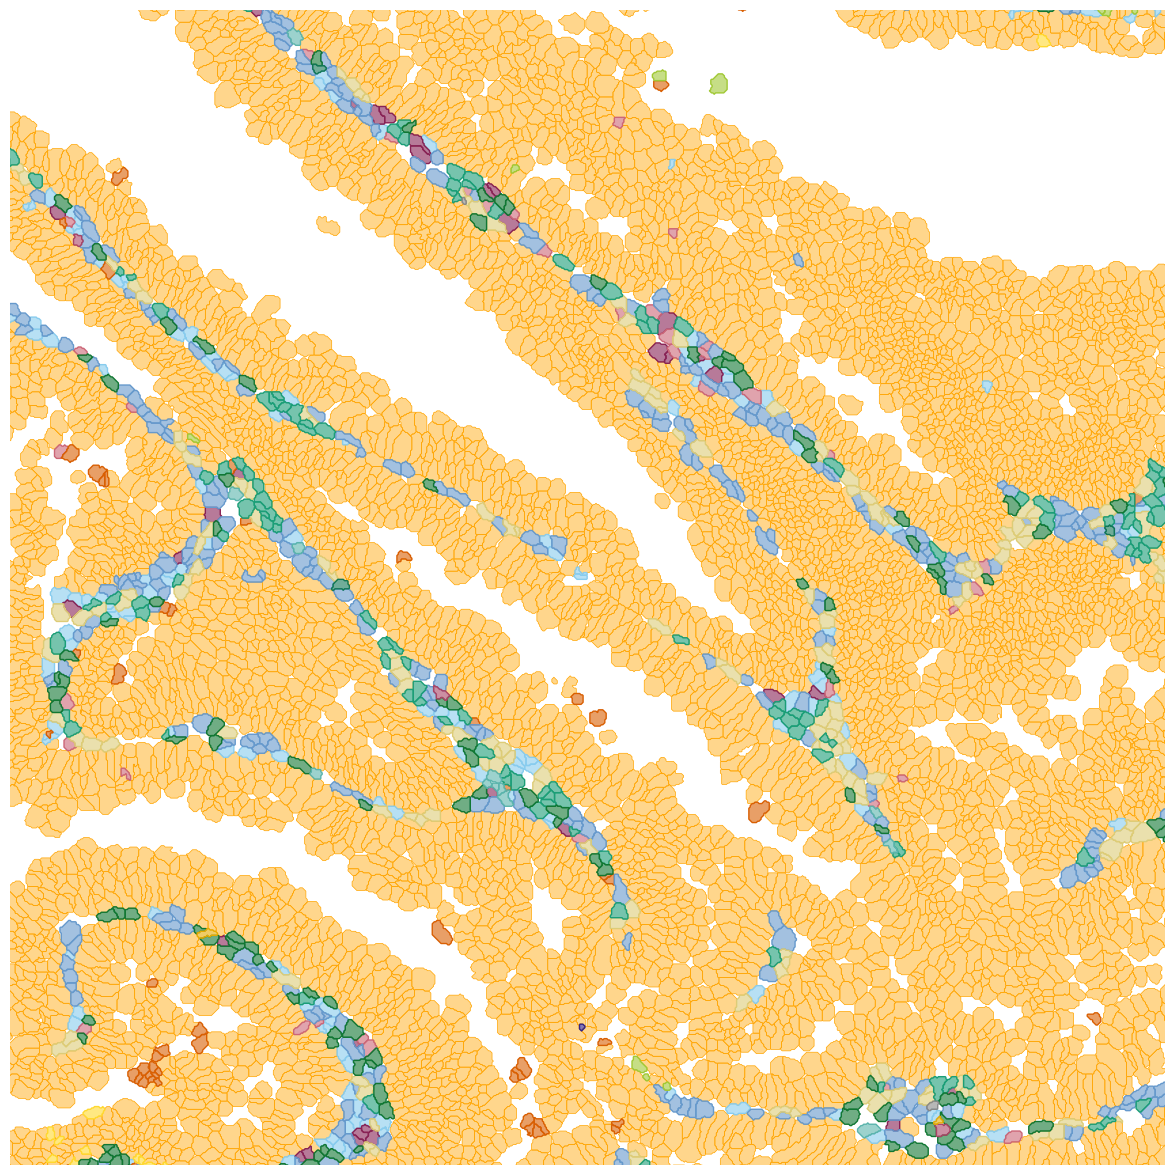

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

plot_annotation(sdata_roi, "cellart_boundaries", ax)

ax.set_xlim(y_min, y_max)
ax.set_ylim(x_min, x_max)
plt.show()